In [14]:
import numpy as np
import pandas as pd
import random
from pandas import read_csv
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import scipy.io

def make_windows(
  arr,
  win_size,
  step_size,
):
  w_list = list()
  n_records = arr.shape[0]
  remainder = (n_records - win_size) % step_size 
  num_windows = 1 + int((n_records - win_size - remainder) / step_size)
  for k in range(num_windows):
    w_list.append(arr[k*step_size:win_size-1+k*step_size+1])
  return np.array(w_list)

def load_file(filepath):
    dataframe = read_csv(filepath, header = None)
    return dataframe.values

In [3]:
mat      = scipy.io.loadmat('binned_zscore.mat') 
Behavior = scipy.io.loadmat('binned_behavior.mat')

In [4]:
zscore = pd.DataFrame(mat['binned_zscore']).T.values
behavior = pd.DataFrame(Behavior['binned_behavior']).values

drop_index = np.where((behavior[0, :] + behavior[1, :]) == 0)
zscore = np.delete(zscore, drop_index, axis = 1)
behavior = np.delete(behavior, drop_index, axis = 1)
print(zscore.shape)
print(behavior.shape)

(110, 6184)
(2, 6184)


In [5]:
tr_zscore = []
for i in range(110):
    tr_zscore.append(make_windows(zscore[i, :], 5, 1))
tr_zscore = np.asarray(tr_zscore)
window_zscore = []
for i in range(6180):
    window_zscore.append(tr_zscore[:, i, :])
window_zscore = np.asarray(window_zscore)
window_zscore.shape

(6180, 110, 5)

In [6]:
behavior = np.delete(behavior, range(4), axis = 1)
window_behavior = np.zeros((6180))
for i in range(6180):
    if behavior[0, i] == 1:
        window_behavior[i] = 1
    else:
        window_behavior[i] = 0

In [7]:
index0 = np.where(window_behavior == 0)
index1 = np.where(window_behavior == 1)

In [8]:
print(len(index0[0]))
print(len(index1[0]))

1535
4645


In [9]:
window_zscore   = np.delete(window_zscore  , 6179, axis = 0)
window_behavior = np.delete(window_behavior, 0   , axis = 0)

In [10]:
print(window_zscore  .shape)
print(window_behavior.shape)

(6179, 110, 5)
(6179,)


# Model Build: 1D CNN 

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(window_zscore, window_behavior, test_size = 0.3, random_state = 1)
print(X_train.shape)
print(Y_train.shape)

(4325, 110, 5)
(4325,)


In [15]:
cnn1d_encoder = Sequential([
    Conv1D(filters = 128, kernel_size = 3, activation = 'relu', input_shape = (110, 5)), 
    MaxPooling1D(pool_size = 2),
    Conv1D(filters = 64, kernel_size = 3, activation = 'relu'), 
    # Dropout(0.5), 
    MaxPooling1D(pool_size = 2), 
    Conv1D(filters = 32, kernel_size = 3, activation = 'relu'), 
    MaxPooling1D(pool_size = 2), 
    Flatten()
])
cnn1d_decoder = Sequential([
    Dense(256, activation = 'relu', input_shape = (cnn1d_encoder.output.shape[1], )), 
    Dense(128, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
cnn1d_autoencoder = Model(inputs = cnn1d_encoder.input, outputs = cnn1d_decoder(cnn1d_encoder.output))
cnn1d_autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
cnn1d_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3_input (InputLayer)  [(None, 110, 5)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 108, 128)          2048      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 54, 128)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 52, 64)            24640     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 26, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 32)            6176

In [16]:
model_history2 = cnn1d_autoencoder.fit(X_train, Y_train, epochs=200, batch_size=32,
                                       validation_split = .2, 
                                       verbose=1)

Epoch 1/200
109/109 [==============================] - 2s 13ms/step - loss: 0.3768 - accuracy: 0.8370 - val_loss: 0.3303 - val_accuracy: 0.8601
Epoch 2/200
109/109 [==============================] - 1s 11ms/step - loss: 0.1602 - accuracy: 0.9355 - val_loss: 0.2140 - val_accuracy: 0.9133
Epoch 3/200
109/109 [==============================] - 1s 10ms/step - loss: 0.0923 - accuracy: 0.9633 - val_loss: 0.1837 - val_accuracy: 0.9399
Epoch 4/200
109/109 [==============================] - 1s 11ms/step - loss: 0.0547 - accuracy: 0.9815 - val_loss: 0.1840 - val_accuracy: 0.9387
Epoch 5/200
109/109 [==============================] - 1s 10ms/step - loss: 0.0584 - accuracy: 0.9801 - val_loss: 0.1186 - val_accuracy: 0.9526
Epoch 6/200
109/109 [==============================] - 1s 11ms/step - loss: 0.0469 - accuracy: 0.9838 - val_loss: 0.1117 - val_accuracy: 0.9688
Epoch 7/200
109/109 [==============================] - 1s 11ms/step - loss: 0.0407 - accuracy: 0.9844 - val_loss: 0.1468 - val_accuracy:

109/109 [==============================] - 1s 11ms/step - loss: 2.5537e-05 - accuracy: 1.0000 - val_loss: 0.2310 - val_accuracy: 0.9746
Epoch 58/200
109/109 [==============================] - 1s 11ms/step - loss: 1.8061e-05 - accuracy: 1.0000 - val_loss: 0.2371 - val_accuracy: 0.9746
Epoch 59/200
109/109 [==============================] - 1s 11ms/step - loss: 1.3558e-05 - accuracy: 1.0000 - val_loss: 0.2426 - val_accuracy: 0.9757
Epoch 60/200
109/109 [==============================] - 1s 11ms/step - loss: 1.0117e-05 - accuracy: 1.0000 - val_loss: 0.2463 - val_accuracy: 0.9757
Epoch 61/200
109/109 [==============================] - 1s 11ms/step - loss: 8.1900e-06 - accuracy: 1.0000 - val_loss: 0.2451 - val_accuracy: 0.9757
Epoch 62/200
109/109 [==============================] - 1s 11ms/step - loss: 7.0319e-06 - accuracy: 1.0000 - val_loss: 0.2526 - val_accuracy: 0.9757
Epoch 63/200
109/109 [==============================] - 1s 11ms/step - loss: 5.0977e-06 - accuracy: 1.0000 - val_loss: 

Epoch 112/200
109/109 [==============================] - 1s 10ms/step - loss: 2.3241e-08 - accuracy: 1.0000 - val_loss: 0.3322 - val_accuracy: 0.9769
Epoch 113/200
109/109 [==============================] - 1s 11ms/step - loss: 2.1604e-08 - accuracy: 1.0000 - val_loss: 0.3332 - val_accuracy: 0.9769
Epoch 114/200
109/109 [==============================] - 1s 11ms/step - loss: 2.0462e-08 - accuracy: 1.0000 - val_loss: 0.3342 - val_accuracy: 0.9769
Epoch 115/200
109/109 [==============================] - 1s 12ms/step - loss: 1.8876e-08 - accuracy: 1.0000 - val_loss: 0.3352 - val_accuracy: 0.9769
Epoch 116/200
109/109 [==============================] - 1s 11ms/step - loss: 1.7858e-08 - accuracy: 1.0000 - val_loss: 0.3365 - val_accuracy: 0.9769
Epoch 117/200
109/109 [==============================] - 1s 11ms/step - loss: 1.7472e-08 - accuracy: 1.0000 - val_loss: 0.3369 - val_accuracy: 0.9769
Epoch 118/200
109/109 [==============================] - 1s 11ms/step - loss: 1.6210e-08 - accuracy:

109/109 [==============================] - 1s 10ms/step - loss: 1.5461e-09 - accuracy: 1.0000 - val_loss: 0.3766 - val_accuracy: 0.9769
Epoch 167/200
109/109 [==============================] - 1s 10ms/step - loss: 1.4408e-09 - accuracy: 1.0000 - val_loss: 0.3773 - val_accuracy: 0.9769
Epoch 168/200
109/109 [==============================] - 1s 10ms/step - loss: 1.3958e-09 - accuracy: 1.0000 - val_loss: 0.3773 - val_accuracy: 0.9769
Epoch 169/200
109/109 [==============================] - 1s 10ms/step - loss: 1.3050e-09 - accuracy: 1.0000 - val_loss: 0.3786 - val_accuracy: 0.9769
Epoch 170/200
109/109 [==============================] - 1s 10ms/step - loss: 1.2603e-09 - accuracy: 1.0000 - val_loss: 0.3791 - val_accuracy: 0.9769
Epoch 171/200
109/109 [==============================] - 1s 10ms/step - loss: 1.2125e-09 - accuracy: 1.0000 - val_loss: 0.3803 - val_accuracy: 0.9769
Epoch 172/200
109/109 [==============================] - 1s 10ms/step - loss: 1.1571e-09 - accuracy: 1.0000 - val_

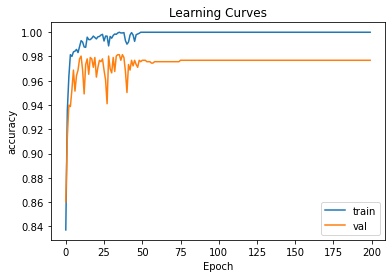

In [17]:
from matplotlib import pyplot
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('accuracy')
pyplot.plot(model_history2.history['accuracy'], label='train')
pyplot.plot(model_history2.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
pred = (cnn1d_autoencoder.predict(X_test)> 0.5).reshape((1854, ))
pred = np.multiply(pred, 1)

In [21]:
pred.shape

(1854,)

In [22]:
accuracy_score(Y_test, pred)

0.9795037756202805

In [24]:
1854 - (0.9795037756202805 * 1854)

38.0